**CLTV Prediction with BG-NBD and Gamma-Gamma**

In [1]:
!pip install lifetimes
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_ = pd.read_excel("/kaggle/input/online-retails/online_retail_II.xlsx", sheet_name= "Year 2010-2011")
df = df_.copy()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.8 MB/s eta 0:00:00


In [2]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

*Outlier Functions*

In [3]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range

    if dataframe[variable].dtype != 'O':
        up_limit = round(up_limit)
        low_limit = round(low_limit)

    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [4]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

df["TotalPrice"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


*Creating CLTV DF*

In [5]:
df["InvoiceDate"].max() ## Timestamp('2011-12-09 12:50:00')
today_date = dt.datetime(2011, 12, 11)

cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                                                         lambda InvoiceDate : (today_date - InvoiceDate.min()).days],
                                         'Invoice': lambda Invoice: Invoice.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,309.9200
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.2400
12349.0000,0,19,1,1491.6000
12350.0000,0,311,1,331.4000


In [6]:
### WEEKLY ###


cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"] 

cltv_df = cltv_df[(cltv_df["frequency"] > 1)] 

cltv_df["recency"] = cltv_df["recency"] / 7 

cltv_df["T"] = cltv_df["T"] / 7 

cltv_df.describe().T

cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.5600
12352.0000,37.1429,42.4286,8,219.4675
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.0300


*Applying BG/NBD Model*

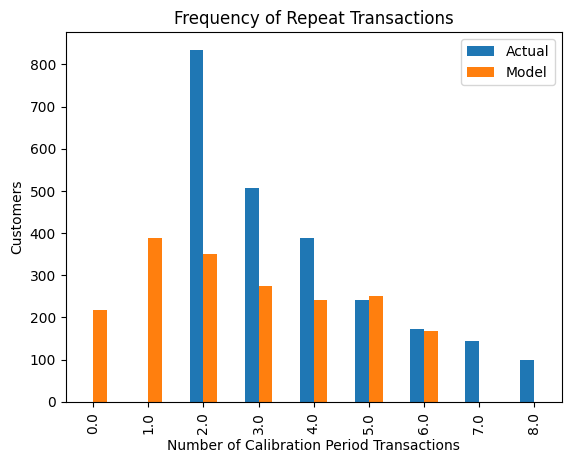

In [7]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])


#bgf.conditional_expected_number_of_purchases_up_to_time(1,
#                                                        cltv_df['frequency'],
#                                                        cltv_df['recency'],
#                                                        cltv_df['T']).sort_values(ascending=False).head(10)
#

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)


## 3 months prediction ##

cltv_df["expected_purc_3_month"] = bgf.predict(4 *3,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

plot_period_transactions(bgf)
plt.show()

*Applying Gamma-Gamma Model*

In [8]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)


cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,
12415.0000,44.7143,48.2857,21,5723.7614,4.5080,5771.6321
12590.0000,0.0000,30.2857,2,4590.9800,0.1363,5029.2048
12435.0000,26.8571,38.2857,2,3914.9450,0.9035,4288.9406
12409.0000,14.7143,26.1429,3,3690.8900,1.3854,3918.8108
14088.0000,44.5714,46.1429,13,3864.5315,3.0896,3917.1059
18102.0000,52.2857,52.5714,60,3857.0120,11.5112,3868.2618
12753.0000,48.4286,51.8571,6,3571.5650,1.4973,3678.5774
14646.0000,50.4286,50.7143,73,3645.7085,14.3340,3654.4467
15749.0000,13.8571,47.5714,3,3023.7067,0.3320,3210.6659


**CLCTV Calculation with BG-NBD and Gamma-Gamma**

In [9]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,
                                   freq="W",
                                   discount_rate=0.01)

cltv.head() #Index'te ID bilgisi var, resetleyeceğiz
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12347.0000,1128.4474
1,12348.0000,538.6448
2,12352.0000,517.3235
3,12356.0000,1083.0897
4,12358.0000,966.3704


In [10]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10) 

,Customer ID,recency,T,frequency,monetary,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3645.7085,14.3340,3654.4467,55735.4698
2761,18102.0000,52.2857,52.5714,60,3857.0120,11.5112,3868.2618,47379.0803
843,14096.0000,13.8571,14.5714,17,3163.5424,8.5526,3196.3894,29061.2374
36,12415.0000,44.7143,48.2857,21,5723.7614,4.5080,5771.6321,27682.4807
1257,14911.0000,53.1429,53.4286,201,691.6786,37.1641,692.2948,27376.1649
2458,17450.0000,51.2857,52.5714,46,2861.0689,8.8830,2871.9843,27145.1343
874,14156.0000,51.5714,53.1429,55,2103.8965,10.4298,2110.6236,23422.9533
2487,17511.0000,52.8571,53.4286,31,2933.8684,6.0476,2950.5049,18986.1282
2075,16684.0000,50.4286,51.2857,28,2209.2364,5.6801,2223.1476,13435.9567
650,13694.0000,52.7143,53.4286,50,1275.6430,9.5186,1280.1605,12965.5499


*Creating CLTV Segments*

In [11]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(50)

cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                     recency                        T                  frequency             monetary                   expected_purc_3_month                 expected_average_profit                         clv                   
               mean           sum count    mean        sum count    mean        sum count      mean   sum count     mean         sum count                  mean       sum count                    mean         sum count      mean          sum count
segment                                                                                                                                                                                                                                                
D        15558.4761 11077635.0000   712 22.0738 15716.5714   712 40.4649 28811.0000   712    3.0646  2182   712 183.9537 130975.0318   712                0.8400  598.0905   712                199.4275 141992.3870   712  143.2919  102023.8666   712
C        15309.6343 10885150.0000   711 30.6697 21806.1429   711 38.1111 27097.0000   711    4.0956  2912   711 271.6890 193170.8954   711                1.4251 1013.2176   711                289.9793 206175.2655   711  380.7837  270737.2150   711
B        15352.8186 10915854.0000   711 29.5148 20985.0000   711 34.8117 24751.1429   711    5.4416  3869   711 373.4339 265511.5213   711                1.9165 1362.6595   711                393.8852 280052.3738   711  688.2502  489345.9077   711
A        14947.3586 10627572.0000   711 31.4109 22333.1429   711 34.4840 24518.1429   711   11.3586  8076   711 659.8045 469121.0327   711                3.2309 2297.1448   711                685.8436 487634.8242   711 2222.1219 1579928.6403   711

In [12]:
cltv_final.sort_values(by="expected_purc_3_month",ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_3_month,expected_average_profit,clv,segment
215,12748.0000,53.1429,53.4286,209,154.9265,38.6276,155.0731,6373.7072,A
1257,14911.0000,53.1429,53.4286,201,691.6786,37.1641,692.2948,27376.1649,A
2652,17841.0000,53.0000,53.4286,124,330.1252,23.0625,330.6179,8113.1517,A
373,13089.0000,52.2857,52.8571,97,606.3606,18.2736,607.4858,11811.7431,A
1101,14606.0000,53.1429,53.4286,93,130.1371,17.4010,130.4205,2414.7818,A
1441,15311.0000,53.2857,53.4286,91,667.7791,17.0411,669.0960,12132.2865,A
319,12971.0000,52.5714,53.2857,86,127.4815,16.1292,127.7827,2193.0066,A
1122,14646.0000,50.4286,50.7143,73,3645.7085,14.3340,3654.4467,55735.4698,A
511,13408.0000,53.0000,53.4286,62,453.5006,11.7223,454.8338,5673.0938,A
2761,18102.0000,52.2857,52.5714,60,3857.0120,11.5112,3868.2618,47379.0803,A


In [13]:
cltv_final.sort_values(by="clv",ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_3_month,expected_average_profit,clv,segment
1122,14646.0000,50.4286,50.7143,73,3645.7085,14.3340,3654.4467,55735.4698,A
2761,18102.0000,52.2857,52.5714,60,3857.0120,11.5112,3868.2618,47379.0803,A
843,14096.0000,13.8571,14.5714,17,3163.5424,8.5526,3196.3894,29061.2374,A
36,12415.0000,44.7143,48.2857,21,5723.7614,4.5080,5771.6321,27682.4807,A
1257,14911.0000,53.1429,53.4286,201,691.6786,37.1641,692.2948,27376.1649,A
2458,17450.0000,51.2857,52.5714,46,2861.0689,8.8830,2871.9843,27145.1343,A
874,14156.0000,51.5714,53.1429,55,2103.8965,10.4298,2110.6236,23422.9533,A
2487,17511.0000,52.8571,53.4286,31,2933.8684,6.0476,2950.5049,18986.1282,A
2075,16684.0000,50.4286,51.2857,28,2209.2364,5.6801,2223.1476,13435.9567,A
650,13694.0000,52.7143,53.4286,50,1275.6430,9.5186,1280.1605,12965.5499,A
